Tutorial - Part #2 - Spatially variant PSF
=======================


This package hosts a simple implementation of the proposed technique by Lauer 2002.

The technique performs a linear decomposition of the PSF into several *basis* elements of small
size (much smaller than the image) normalized to unit sum. 
Each of these *autopsfs* come with a coefficient, which is not normalized, that have the same size of the image.

To perform the decomposition uses the *Karhunen-Loeve* transform,
in order to calculate the *basis* as a linear expansion of the 
*psf observations* --which are cutout stamps of the stars in the image.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

from properimage import single_image as s

%matplotlib inline

In [2]:
import os
import shlex
import subprocess
import sys

import numpy as np
import matplotlib.pyplot as plt


from properimage.tests import simtools
from properimage import propercoadd as pc
from properimage import single_image as si
from properimage import utils
from properimage import plot

We simulate an image with several star shapes across the field

In [3]:
frames = []
for theta in [0, 45, 105, 150]:
    N = 512  # side
    X_FWHM = 5 + 2.5*theta/180
    Y_FWHM = 5
    t_exp = 5
    max_fw = max(X_FWHM, Y_FWHM)
    #test_dir = os.path.abspath('./test/test_images/psf_basis_kl_gs')

    x = np.random.randint(low=6*max_fw, high=N-6*max_fw, size=80)
    y = np.random.randint(low=6*max_fw, high=N-6*max_fw, size=80)
    xy = [(x[i], y[i]) for i in range(80)]

    SN =  30. # SN para poder medir psf
    weights = list(np.linspace(10, 1000., len(xy)))
    m = simtools.delta_point(N, center=False, xy=xy, weights=weights)
    im = simtools.image(m, N, t_exp, X_FWHM, Y_FWHM=Y_FWHM, theta=theta,
                        SN=SN, bkg_pdf='gaussian')
    frames.append(im+100.)

mean = 0, std = 1.21321619394, b = 36.3964858183, SN = 30.0
mean = 0, std = 0.991318394466, b = 29.739551834, SN = 30.0
mean = 0, std = 1.18506054726, b = 35.5518164177, SN = 30.0
mean = 0, std = 0.987467390057, b = 29.6240217017, SN = 30.0


In [4]:
frame = np.zeros((1024, 1024))
for j in range(2):
    for i in range(2):
        frame[i*512:(i+1)*512, j*512:(j+1)*512] = frames[i+2*j]

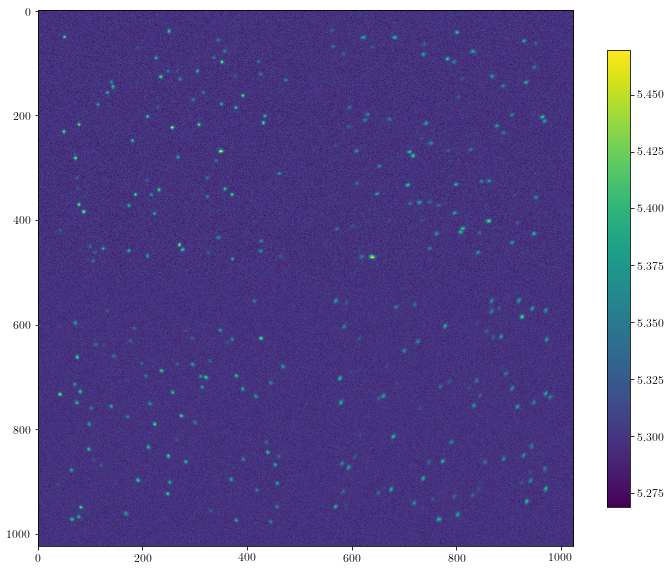

In [5]:
plt.figure(figsize=(12, 12))
plt.imshow(np.log(frame), interpolation='none')
plt.colorbar(shrink=0.7)

We perform the psf extraction. This is possible to do with a context manager, in order to *autoclean* the disk files where the star stamps are stored.

In [57]:
with si.SingleImage(frame, smooth_psf=False) as sim:
    a_fields, psf_basis = sim.get_variable_psf(inf_loss=0.1)
    x, y = sim.get_afield_domain()

Sources found = 111
stamps will be 17 x 17
('Masked pixels: ', 0)
cleaning... 


In [58]:
print(len(psf_basis))

9


If we plot the coefficients, they look as smooth fields of the same size of the image. 

Whenever they grow they show where the corresponding *autopsf* element is more important than others.

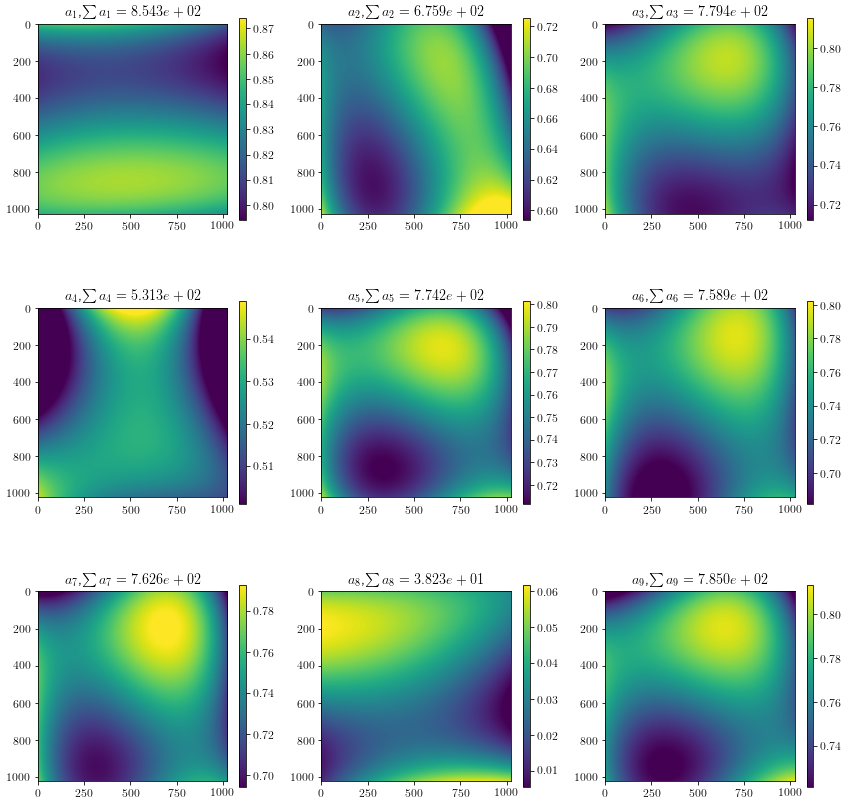

In [59]:
plot.plot_afields(a_fields=a_fields, x=x, y=y, nbook=True)

The *autopsf* elements are small patches, like the ones below.

The principal component psf is the first element of this list of arrays.

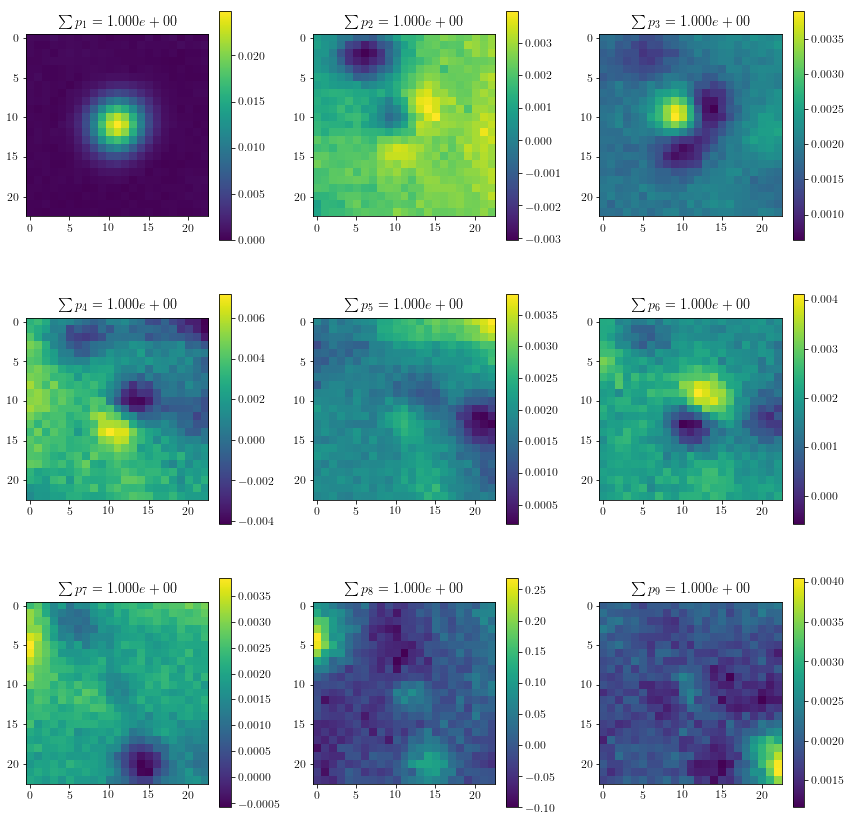

In [60]:
plot.plot_psfbasis(psf_basis=psf_basis, nbook=True)